#Model Training: ResNet18 & MobileNetV2 CNN

This notebook provides the tools to train Convolutional Neural Networks (CNNs) based on the MobileNetV2 and ResNet18 architectures using transfer learning techniques.

It documents the experiments we conducted as part of our research.

You can train the models using the preprocessed dataset provided (a subset of the BirdCLEF 2021 competition), which is available in the repository files.

Alternatively, you may use the original BirdCLEF 2021 audio dataset or other audio datasets. In that case, you will first need to convert all audio files into Mel-Spectrogram representations and prepare the data using the other Jupyter notebooks included in this project.

The models are designed to learn from relatively short and centered audio fragments. If you use different data or modify the trimming logic, ensure that bird vocalizations are not lost or misaligned.

Once your data is ready, this notebook will allow you to:

- Load and preprocess the dataset

- Train the three models used in the experiment

- Monitor training performance and accuracy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import matplotlib.pyplot as plt
import ast
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import time
from torchvision.models import resnet18

dir = '/content/drive/Shared drives/Deep Learning Group G/UPF_Deep_Learning_2025/Final Project/Birdclef2021/' # your path.
os.chdir(dir)

Mounted at /content/drive


In [ ]:
class BirdSpectrogramDataset(Dataset):
    def __init__(self, csv_path, npy_folder, transform=None):
        self.npy_folder = npy_folder
        self.transform = transform

        # Load CSV
        data = pd.read_csv(csv_path)

        # List of .npy filenames in the folder
        npy_files = set(os.listdir(npy_folder))

        # Filter CSV to only keep rows where filename.ogg.npy exists
        filtered_rows = []
        for _, row in data.iterrows():
            filename = row['filename'] + '.npy'  # e.g., XC618945.ogg.npy
            if filename in npy_files:
                filtered_rows.append(row)

        # Create final DataFrame
        self.data = pd.DataFrame(filtered_rows)

        print(f"Loaded {len(self.data)} valid entries out of {len(data)} total")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        npy_filename = row['filename'] + '.npy'
        npy_path = os.path.join(self.npy_folder, npy_filename)

        spectrogram = np.load(npy_path)
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32)

        if self.transform:
            spectrogram = self.transform(spectrogram)

        label = torch.tensor(row['label_id'], dtype=torch.long)
        return spectrogram, label

In [ ]:
# Paths
LABELS_CSV = dir + "update_metadata1.csv"
DATA_DIR = dir + "train_good/"

# Create dataset and dataloader
dataset = BirdSpectrogramDataset(csv_path=LABELS_CSV, npy_folder=DATA_DIR)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define the split ratio
val_ratio = 0.3  # 30% for validation
total_size = len(dataset)
val_size = int(total_size * val_ratio)
train_size = total_size - val_size

# Randomly split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create separate dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# Visualize one batch
for X, y in val_loader:
    print(X.shape)  # Expected shape: (B, 12, mel_bins, time)
    print(y)        # Expected shape: (B,)
    break

Loaded 587 valid entries out of 2892 total
torch.Size([16, 10, 128, 321])
tensor([0, 2, 2, 4, 1, 0, 1, 0, 1, 5, 5, 4, 5, 3, 3, 3])


In [ ]:
def train(model, loader, loss_function, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = train_loss / total
    epoch_acc = correct / total
    train_time = time.time() - start_time
    return epoch_loss, epoch_acc, train_time

def evaluate(model, loader, loss_function, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = val_loss / total
    epoch_acc = correct / total
    val_time = time.time() - start_time
    return epoch_loss, epoch_acc, val_time

def compute_model_params(model: nn.Module) -> int:
    """
    Computes the total number of trainable parameters in a PyTorch model.

    Also issues a warning if the number of parameters exceeds a defined threshold.

    Args:
        model (nn.Module): The PyTorch model to evaluate.
        max_params (int, optional): Maximum allowed parameters before warning is triggered. Default is 150,000.

    Returns:
        int: Total number of trainable parameters in the model.
    """
    total_params = 0

    # Iterate through all parameters and sum their sizes
    for param in model.parameters():
        total_params += param.numel()

    return total_params

Training MobileNetV2

In [ ]:
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True)
        )

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super().__init__()
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(in_channels, hidden_dim, kernel_size=1, stride=1))
        layers.extend([
            ConvBNReLU(hidden_dim, hidden_dim, kernel_size=3, stride=stride, groups=hidden_dim),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MyEfficientCNN_MobileNetV2(nn.Module):
    def __init__(self, num_classes=10):
        super(MyEfficientCNN_MobileNetV2, self).__init__()
        input_channel = 16
        last_channel = 128

        # Configuración MobileNetV2

        settings = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 2, 2],
            [6, 64, 1, 1]
        ]

        #First layer with 32x32 input
        layers = [ConvBNReLU(10, input_channel, kernel_size=3, stride=1)]

        #Rest of layers
        for t, c, n, s in settings:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedResidual(input_channel, c, stride, expand_ratio=t))
                input_channel = c

        #Last Layer
        layers.append(ConvBNReLU(input_channel, last_channel, kernel_size=1, stride=1))
        self.conv_layers = nn.Sequential(*layers) #El * en (*layers) es el desempaquetado de la lista, equivale a escribir nn.Sequential(layer1, layer2, layer3, ...), como lo hacemos dinamicamente es mejor con el *.



        # Clasificador
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(last_channel, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyEfficientCNN_MobileNetV2(num_classes=6).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4, momentum=0.9)

print(f"Total parameters of the model:  {compute_model_params(model)}")

num_epochs = 20

loss_list = []
val_loss_list = []
train_acc_list = []
val_acc = []
train_times = []
val_times = []

for epoch in range(num_epochs):

    train_loss, train_acc, train_time = train(model, train_loader, loss_function, optimizer, device)
    test_loss, test_acc, val_time = evaluate(model, val_loader, loss_function, device)

    loss_list.append(train_loss)
    val_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    val_acc.append(test_acc)
    train_times.append(train_time)
    val_times.append(val_time)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Training loss: {train_loss:.4f} | Training accuracy: {train_acc:.4f} | Training time: {train_time:.4f} sec")
    print(f"  Validation loss: {test_loss:.4f} | Validation accuracy: {test_acc:.4f} | Validation time: {val_time:.4f} sec")

Total parameters of the model:  194422
Epoch 1/20
  Training loss: 1.7860 | Training accuracy: 0.2336 | Training time: 45.2111 sec
  Validation loss: 2.6686 | Validation accuracy: 0.1534 | Validation time: 10.0451 sec
Epoch 2/20
  Training loss: 1.6539 | Training accuracy: 0.3260 | Training time: 5.2010 sec
  Validation loss: 1.8633 | Validation accuracy: 0.2841 | Validation time: 1.1183 sec
Epoch 3/20
  Training loss: 1.5285 | Training accuracy: 0.4088 | Training time: 4.9942 sec
  Validation loss: 1.6900 | Validation accuracy: 0.3125 | Validation time: 1.1375 sec
Epoch 4/20
  Training loss: 1.3971 | Training accuracy: 0.4647 | Training time: 5.1193 sec
  Validation loss: 1.6623 | Validation accuracy: 0.3580 | Validation time: 1.0998 sec
Epoch 5/20
  Training loss: 1.2694 | Training accuracy: 0.5328 | Training time: 4.9523 sec
  Validation loss: 1.6736 | Validation accuracy: 0.3352 | Validation time: 1.1289 sec
Epoch 6/20
  Training loss: 1.1977 | Training accuracy: 0.5718 | Training 

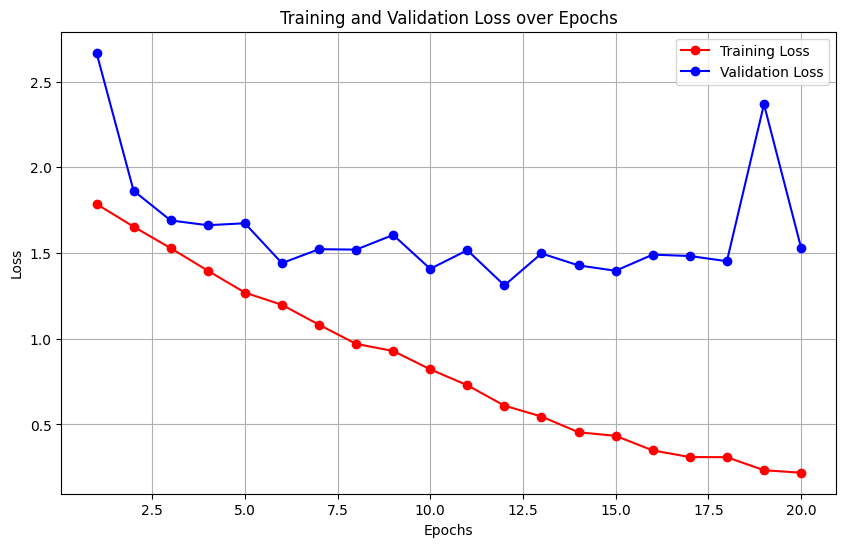

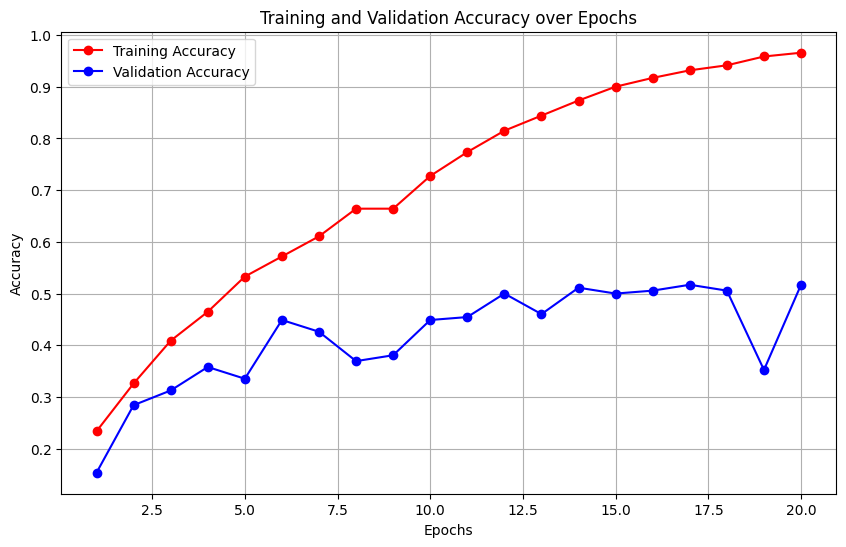

In [ ]:
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_list, label="Training Loss", color='red', marker='o')
plt.plot(epochs, val_loss_list, label="Validation Loss", color='blue', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_list, label="Training Accuracy", color='red', marker='o')
plt.plot(epochs, val_acc, label="Validation Accuracy", color='blue', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Training ResNet18 (Untrained and Pretrained)

In [ ]:
class ResNet18Spectrogram(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18Spectrogram, self).__init__()

        # Load pre-defined ResNet18
        self.model = resnet18(pretrained=False)

        # Modify the first convolution layer to accept 10-channel input
        self.model.conv1 = nn.Conv2d(
            in_channels=10,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )

        # Modify the final fully connected layer to output num_classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


In [ ]:
class PretrainedResNetSpectrogram(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base_model = resnet18(pretrained=True)

        # Modify first layer
        self.conv1 = nn.Conv2d(10, 64, kernel_size=7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            self.conv1.weight[:, :3] = base_model.conv1.weight
            for i in range(3, 10):
                self.conv1.weight[:, i] = base_model.conv1.weight[:, i % 3]

        # Replace original conv1 and final layer
        base_model.conv1 = self.conv1
        base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)

        self.model = base_model

    def forward(self, x):
        return self.model(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
# Instanciar el modelo y moverlo al dispositivo
model = ResNet18Spectrogram(num_classes=10).to(device)
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

print(f"Total parameters of the model:  {compute_model_params(model)}")

num_epochs = 20

loss_list_untrained = []
val_loss_list_untrained = []
train_acc_list_untrained = []
val_acc_untrained = []
train_times = []
val_times = []

for epoch in range(num_epochs):
    train_loss, train_acc, train_time = train(model, train_loader, loss_function, optimizer, device)
    test_loss, test_acc, val_time = evaluate(model, val_loader, loss_function, device)

    loss_list_untrained.append(train_loss)
    val_loss_list_untrained.append(test_loss)
    train_acc_list_untrained.append(train_acc)
    val_acc_untrained.append(test_acc)
    train_times.append(train_time)
    val_times.append(val_time)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Training loss: {train_loss:.4f} | Training accuracy: {train_acc:.4f} | Training time: {train_time:.4f} sec")
    print(f"  Validation loss: {test_loss:.4f} | Validation accuracy: {test_acc:.4f} | Validation time: {val_time:.4f} sec")

cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Total parameters of the model:  11203594
Epoch 1/20
  Training loss: 2.0966 | Training accuracy: 0.2044 | Training time: 3.7681 sec
  Validation loss: 2.7654 | Validation accuracy: 0.2670 | Validation time: 0.9343 sec
Epoch 2/20
  Training loss: 1.4526 | Training accuracy: 0.4477 | Training time: 3.0128 sec
  Validation loss: 2.4542 | Validation accuracy: 0.3523 | Validation time: 0.9978 sec
Epoch 3/20
  Training loss: 1.3402 | Training accuracy: 0.4988 | Training time: 2.9693 sec
  Validation loss: 3.2846 | Validation accuracy: 0.2102 | Validation time: 0.9437 sec
Epoch 4/20
  Training loss: 1.1609 | Training accuracy: 0.5499 | Training time: 3.1593 sec
  Validation loss: 1.3631 | Validation accuracy: 0.5341 | Validation time: 0.9500 sec
Epoch 5/20
  Training loss: 1.0299 | Training accuracy: 0.6010 | Training time: 2.9010 sec
  Validation loss: 5.2892 | Validation accuracy: 0.2614 | Validation time: 0.8852 sec
Epoch 6/20
  Training loss: 0.9127 | Training accuracy: 0.6326 | Training 

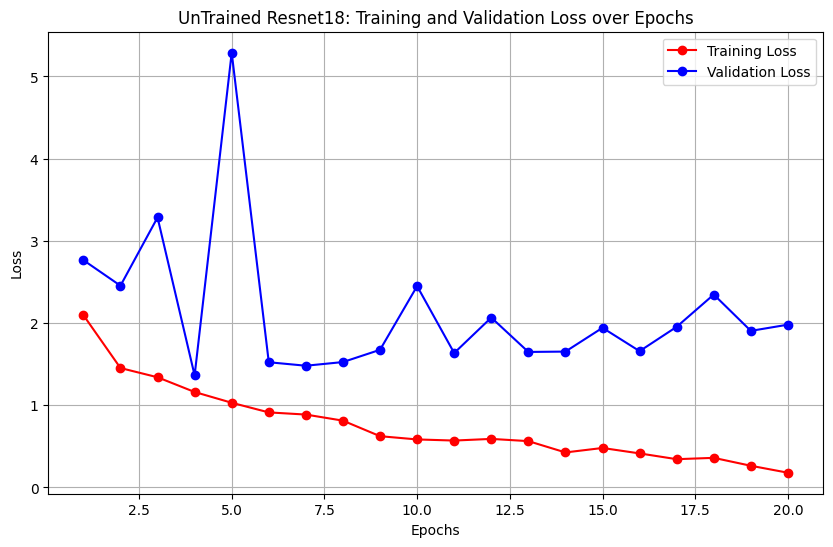

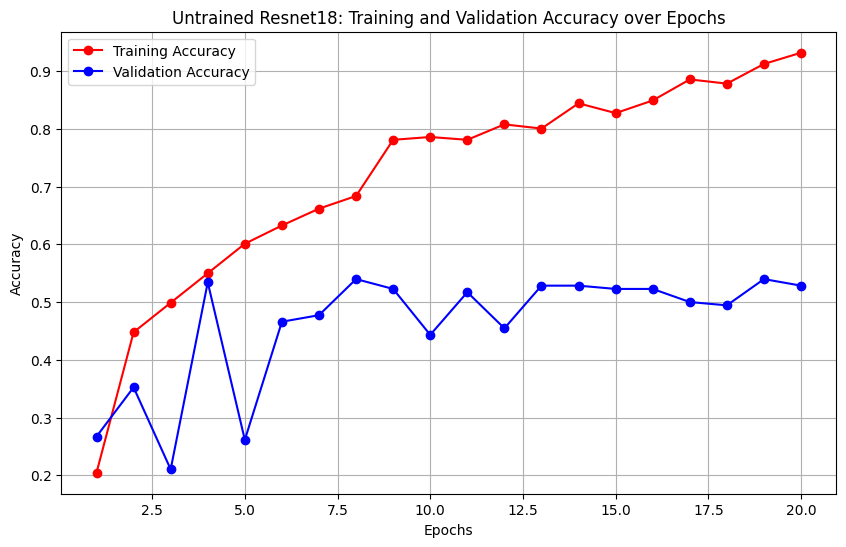

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_list_untrained, label="Training Loss", color='red', marker='o')
plt.plot(epochs, val_loss_list_untrained, label="Validation Loss", color='blue', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('UnTrained Resnet18: Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_list_untrained, label="Training Accuracy", color='red', marker='o')
plt.plot(epochs, val_acc_untrained, label="Validation Accuracy", color='blue', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Untrained Resnet18: Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
# Instanciar el modelo y moverlo al dispositivo
model = PretrainedResNetSpectrogram(num_classes=10).to(device)
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

print(f"Total parameters of the model:  {compute_model_params(model)}")

num_epochs = 20

loss_list_pretrained = []
val_loss_list_pretrained = []
train_acc_list_pretrained = []
val_acc_pretrained = []
train_times = []
val_times = []

for epoch in range(num_epochs):
    train_loss, train_acc, train_time = train(model, train_loader, loss_function, optimizer, device)
    test_loss, test_acc, val_time = evaluate(model, val_loader, loss_function, device)

    loss_list_pretrained.append(train_loss)
    val_loss_list_pretrained.append(test_loss)
    train_acc_list_pretrained.append(train_acc)
    val_acc_pretrained.append(test_acc)
    train_times.append(train_time)
    val_times.append(val_time)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Training loss: {train_loss:.4f} | Training accuracy: {train_acc:.4f} | Training time: {train_time:.4f} sec")
    print(f"  Validation loss: {test_loss:.4f} | Validation accuracy: {test_acc:.4f} | Validation time: {val_time:.4f} sec")

cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]


Total parameters of the model:  11203594
Epoch 1/20
  Training loss: 1.4931 | Training accuracy: 0.4769 | Training time: 3.2776 sec
  Validation loss: 1.2585 | Validation accuracy: 0.6136 | Validation time: 0.9853 sec
Epoch 2/20
  Training loss: 0.7530 | Training accuracy: 0.7251 | Training time: 3.0134 sec
  Validation loss: 1.2478 | Validation accuracy: 0.6307 | Validation time: 0.9657 sec
Epoch 3/20
  Training loss: 0.5839 | Training accuracy: 0.7810 | Training time: 3.1956 sec
  Validation loss: 1.2594 | Validation accuracy: 0.6250 | Validation time: 1.0255 sec
Epoch 4/20
  Training loss: 0.4412 | Training accuracy: 0.8418 | Training time: 3.0764 sec
  Validation loss: 1.1234 | Validation accuracy: 0.6136 | Validation time: 0.9435 sec
Epoch 5/20
  Training loss: 0.3782 | Training accuracy: 0.8832 | Training time: 2.9762 sec
  Validation loss: 0.9335 | Validation accuracy: 0.7443 | Validation time: 0.9717 sec
Epoch 6/20
  Training loss: 0.2939 | Training accuracy: 0.9002 | Training 

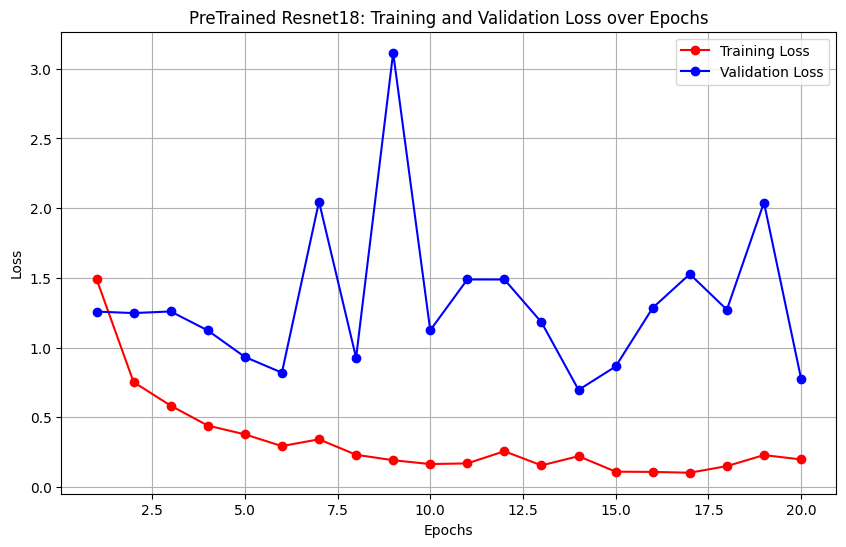

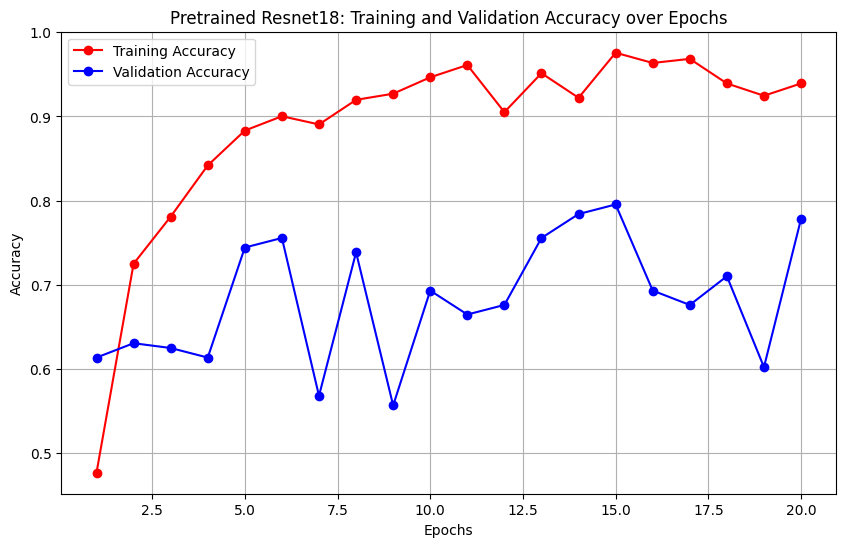

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_list_pretrained, label="Training Loss", color='red', marker='o')
plt.plot(epochs, val_loss_list_pretrained, label="Validation Loss", color='blue', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('PreTrained Resnet18: Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_list_pretrained, label="Training Accuracy", color='red', marker='o')
plt.plot(epochs, val_acc_pretrained, label="Validation Accuracy", color='blue', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Pretrained Resnet18: Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

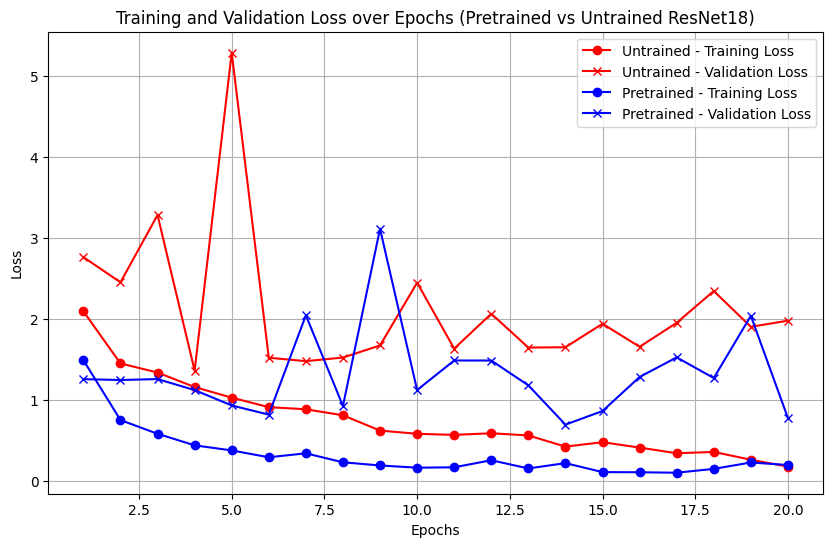

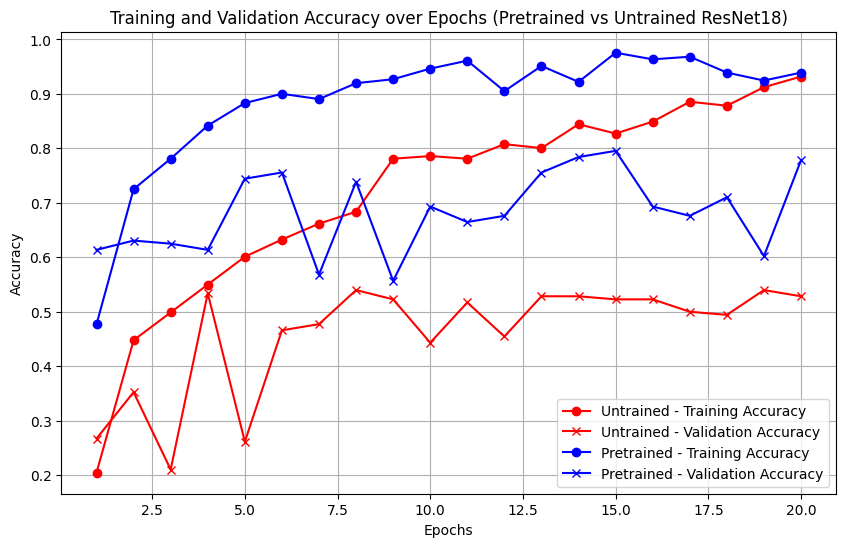

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_list_untrained, label="Untrained - Training Loss", color='red', linestyle='-', marker='o')
plt.plot(epochs, val_loss_list_untrained, label="Untrained - Validation Loss", color='red', linestyle='-', marker='x')
plt.plot(epochs, loss_list_pretrained, label="Pretrained - Training Loss", color='blue', linestyle='-', marker='o')
plt.plot(epochs, val_loss_list_pretrained, label="Pretrained - Validation Loss", color='blue', linestyle='-', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (Pretrained vs Untrained ResNet18)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_list_untrained, label="Untrained - Training Accuracy", color='red', linestyle='-', marker='o')
plt.plot(epochs, val_acc_untrained, label="Untrained - Validation Accuracy", color='red', linestyle='-', marker='x')
plt.plot(epochs, train_acc_list_pretrained, label="Pretrained - Training Accuracy", color='blue', linestyle='-', marker='o')
plt.plot(epochs, val_acc_pretrained, label="Pretrained - Validation Accuracy", color='blue', linestyle='-', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (Pretrained vs Untrained ResNet18)')
plt.legend()
plt.grid(True)
plt.show()


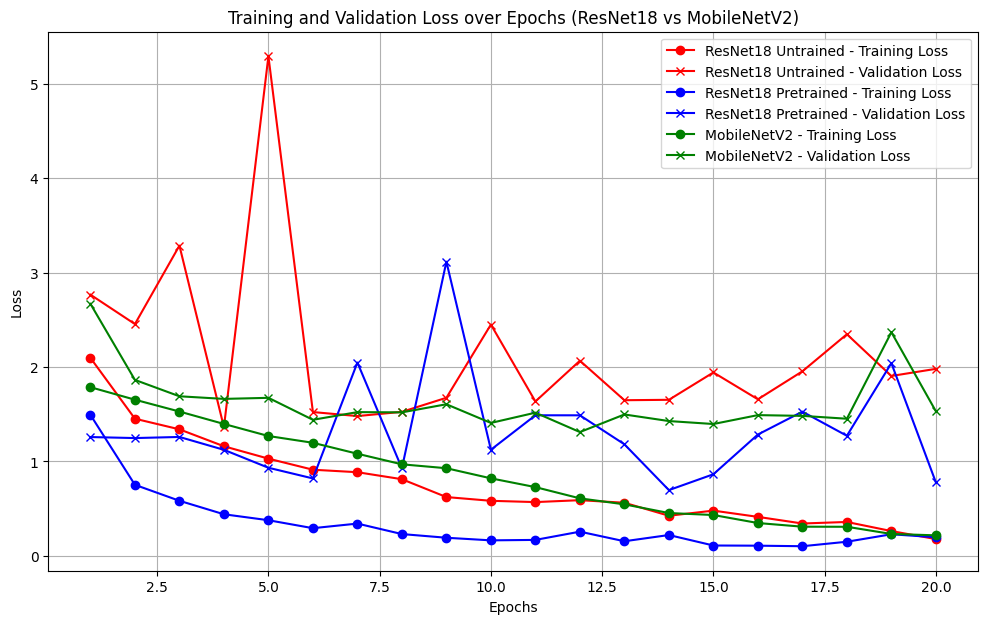

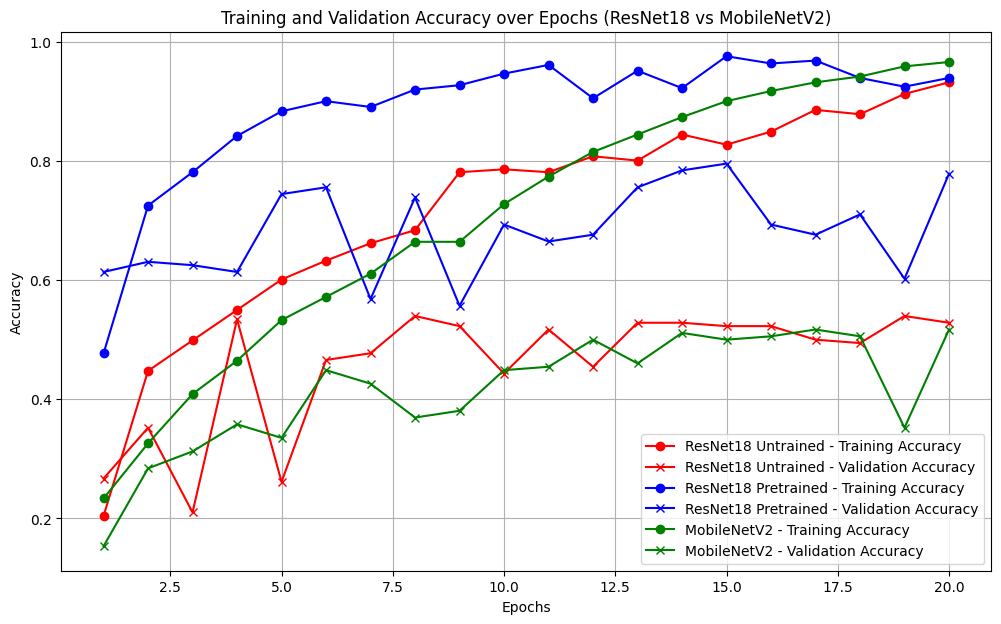

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs + 1))

# Plot Loss comparison
plt.figure(figsize=(12, 7))
# ResNet18 untrained
plt.plot(epochs, loss_list_untrained, label="ResNet18 Untrained - Training Loss", color='red', linestyle='-', marker='o')
plt.plot(epochs, val_loss_list_untrained, label="ResNet18 Untrained - Validation Loss", color='red', linestyle='-', marker='x')
# ResNet18 pretrained
plt.plot(epochs, loss_list_pretrained, label="ResNet18 Pretrained - Training Loss", color='blue', linestyle='-', marker='o')
plt.plot(epochs, val_loss_list_pretrained, label="ResNet18 Pretrained - Validation Loss", color='blue', linestyle='-', marker='x')
# MobileNetV2
plt.plot(epochs, loss_list, label="MobileNetV2 - Training Loss", color='green', linestyle='-', marker='o')
plt.plot(epochs, val_loss_list, label="MobileNetV2 - Validation Loss", color='green', linestyle='-', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (ResNet18 vs MobileNetV2)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy comparison
plt.figure(figsize=(12, 7))
# ResNet18 untrained
plt.plot(epochs, train_acc_list_untrained, label="ResNet18 Untrained - Training Accuracy", color='red', linestyle='-', marker='o')
plt.plot(epochs, val_acc_untrained, label="ResNet18 Untrained - Validation Accuracy", color='red', linestyle='-', marker='x')
# ResNet18 pretrained
plt.plot(epochs, train_acc_list_pretrained, label="ResNet18 Pretrained - Training Accuracy", color='blue', linestyle='-', marker='o')
plt.plot(epochs, val_acc_pretrained, label="ResNet18 Pretrained - Validation Accuracy", color='blue', linestyle='-', marker='x')
# MobileNetV2
plt.plot(epochs, train_acc_list, label="MobileNetV2 - Training Accuracy", color='green', linestyle='-', marker='o')
plt.plot(epochs, val_acc, label="MobileNetV2 - Validation Accuracy", color='green', linestyle='-', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (ResNet18 vs MobileNetV2)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("Final Metrics Summary:\n")

# ResNet18 Untrained
print(f"ResNet18 Untrained:")
print(f"  Final Training Loss: {loss_list_untrained[-1]:.4f}")
print(f"  Final Validation Loss: {val_loss_list_untrained[-1]:.4f}")
print(f"  Final Training Accuracy: {train_acc_list_untrained[-1]*100:.2f}%")
print(f"  Final Validation Accuracy: {val_acc_untrained[-1]*100:.2f}%\n")

# ResNet18 Pretrained
print(f"ResNet18 Pretrained:")
print(f"  Final Training Loss: {loss_list_pretrained[-1]:.4f}")
print(f"  Final Validation Loss: {val_loss_list_pretrained[-1]:.4f}")
print(f"  Final Training Accuracy: {train_acc_list_pretrained[-1]*100:.2f}%")
print(f"  Final Validation Accuracy: {val_acc_pretrained[-1]*100:.2f}%\n")

# MobileNetV2
print(f"MobileNetV2:")
print(f"  Final Training Loss: {loss_list[-1]:.4f}")
print(f"  Final Validation Loss: {val_loss_list[-1]:.4f}")
print(f"  Final Training Accuracy: {train_acc_list[-1]*100:.2f}%")
print(f"  Final Validation Accuracy: {val_acc[-1]*100:.2f}%")

Final Metrics Summary:

ResNet18 Untrained:
  Final Training Loss: 0.1787
  Final Validation Loss: 1.9803
  Final Training Accuracy: 93.19%
  Final Validation Accuracy: 52.84%

ResNet18 Pretrained:
  Final Training Loss: 0.1981
  Final Validation Loss: 0.7783
  Final Training Accuracy: 93.92%
  Final Validation Accuracy: 77.84%

MobileNetV2:
  Final Training Loss: 0.2182
  Final Validation Loss: 1.5313
  Final Training Accuracy: 96.59%
  Final Validation Accuracy: 51.70%
